In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('data/data.csv',parse_dates=True,index_col='DATE')
df.columns=['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

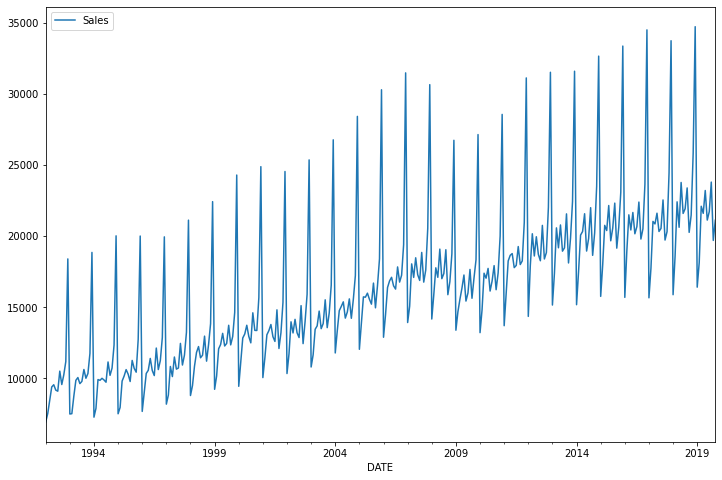

In [3]:
df.plot(figsize=(12,8))

In [4]:
#total dataframe length
len(df)

334

In [5]:
#Data is monthly, let's forecast 1.5 years into the future.
len(df)-18

316

In [6]:
test_size = 18
test_ind = len(df)- test_size

In [7]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [9]:
train.shape

(316, 1)

In [10]:
test .shape

(18, 1)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [12]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [16]:
# What does the first batch look like?
X,y = generator[0]

In [17]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [18]:
y

array([[0.02047633]])

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN

In [46]:
# We're only using one feature in our time series
n_features = 1
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(100,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(1))

In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 100)               10200     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 11,271
Trainable params: 11,271
Non-trainable params: 0
_________________________________________________________________


In [50]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# fit model

In [51]:
model.compile(optimizer='adam',loss='mse')

In [52]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 8.5167e-04
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0018


In [53]:
model.history.history

{'loss': [0.016552334651350975, 0.0038687358610332012, 0.003927687183022499],
 'val_loss': [0.0008516745292581618,
  0.003161731408908963,
  0.0018115165876224637]}

<AxesSubplot:>

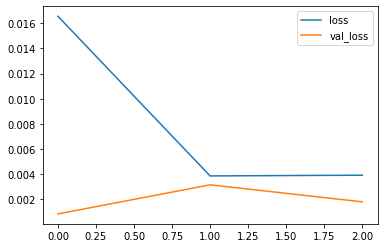

In [54]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [55]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

In [57]:

test['Predictions'] = true_predictions

C:\Users\t\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
test.head()

,Sales,Predictions
DATE,,
2018-05-01,23764,22742.120805
2018-06-01,21589,20655.583364
2018-07-01,21919,21820.026804
2018-08-01,23381,22652.410642
2018-09-01,20260,21574.833033


<AxesSubplot:xlabel='DATE'>

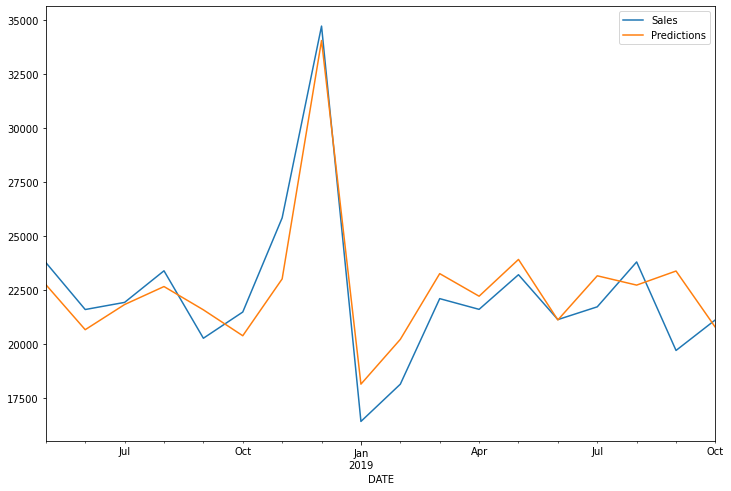

In [59]:
test.plot(figsize=(12,8))

In [60]:
#model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [61]:
# We're only using one feature in our time series
n_features = 1

In [87]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(20))

model.add(Dense(1))


In [88]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_15 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.compile(optimizer='adam', loss='mse')

In [90]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [91]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [92]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0237 - val_loss: 0.0057
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0195 - val_loss: 0.0021
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0131
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 0.0023


In [93]:
losses = pd.DataFrame(model.history.history)

In [94]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [95]:
true_predictions = scaler.inverse_transform(test_predictions)

In [96]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\t\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22325.341140
2018-06-01,21589,21268.797637
2018-07-01,21919,21522.569553
2018-08-01,23381,23342.751882
2018-09-01,20260,20934.172800
2018-10-01,21473,21519.087400
2018-11-01,25831,25363.365659
2018-12-01,34706,37057.075551
2019-01-01,16410,16588.691969


<AxesSubplot:xlabel='DATE'>

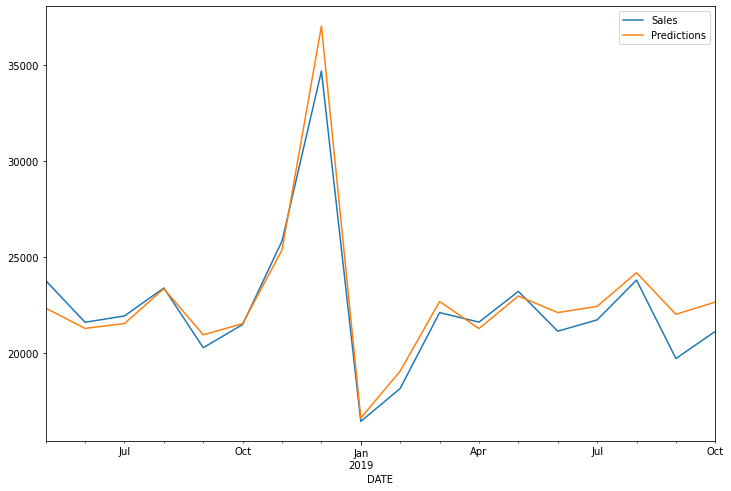

In [98]:
test.plot(figsize=(12,8))